In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import flax.linen as nn
from flax.training.train_state import TrainState
from clu import metrics
import flax
import optax

In [24]:
import pickle

## CNN Inference

C1: conv with 10x10 filter stride 3 32 channels (input 100x100x1, output 31 x 31 x 32)

relu (input 31 x 31 x 32, output 31 x 31 x 32)

max pooling 3x3 stride 2 32 channels (input 31 x 31 x 32, output 15 x 15x 32)

C2: conv with 5x5 filter stride 2 64 channels (input 15 x 15 x 32, output 6 x 6 x 64)

relu (input 6 x 6 x 64, output 6 x 6 x 64)

max pooling 2x2 stride 2 64 channels (input 6 x 6 x 64, output 3 x 3 x 64)

flatten (input 3 x 3 x 64, output 1 x 576)

L1: linear (input 1 x 576, output 1x 576)

relu

L2: linear (input 1 x 576, output 1x 192)

relu

L3: linear (input 1 x 192, output 1x 24)

relu

L4: linear (input 1 x 24, output 1 x 2)

softmax

In [3]:
class CNN(nn.Module):

    @nn.compact
    def __call__(self, imgs): # XXX todo: make sure the sizes all line up
        x = nn.Conv(64, (10, 10), strides=(3, 3), padding='VALID')(imgs)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (3, 3), strides=(2, 2))
        
        x = nn.Conv(128, (5, 5), strides=(2, 2), padding='VALID')(x)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (2, 2), strides=(2, 2))
        
        x = nn.Dense(1024)(x.reshape(imgs.shape[0], -1))
        x = nn.activation.relu(x)
        
        x = nn.Dense(1024)(x)
        x = nn.activation.relu(x)
        
        x = nn.Dense(576)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(192)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(24)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(2)(x)
        return x 

In [4]:
cnn = CNN()
cnn.tabulate(jax.random.PRNGKey(0), jnp.zeros((1, 100, 100, 1)), console_kwargs={'force_jupyter': True})

                                          CNN Summary                                          
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs               ┃ outputs             ┃ params                      ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,100,100,1] │ float32[1,2]        │                             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,100,100,1] │ float32[1,31,31,64] │ bias: float32[64]           │
│         │        │                      │                     │ kernel: float32[10,10,1,64] │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 6,464 (25.9 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_1  │ Conv   │ float32[1,15,15,64]  │ float32[1,6,6,128]  │ bias: float32[128]          │
│         │        │                      │                     │ kernel: float32[5,5,64,128] │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 204,928 (819.7 KB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,1152]      │ float32[1,1024]     │ bias: float32[1024]         │
│         │        │                      │                     │ kernel: float32[1152,1024]  │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 1,180,672 (4.7 MB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,1024]      │ float32[1,1024]     │ bias: float32[1024]         │
│         │        │                      │                     │ kernel: float32[1024,1024]  │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 1,049,600 (4.2 MB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_2 │ Dense  │ float32[1,1024]      │ float32[1,576]      │ bias: float32[576]          │
│         │        │                      │                     │ kernel: float32[1024,576]   │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 590,400 (2.4 MB)            │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_3 │ Dense  │ float32[1,576]       │ float32[1,192]      │ bias: float32[192]          │
│         │        │                      │                     │ kernel: float32[576,192]    │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 110,784 (443.1 KB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_4 │ Dense  │ float32[1,192]       │ float32[1,24]       │ bias: float32[24]           │
│         │        │                      │                     │ kernel: float32[192,24]     │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 4,632 (18.5 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_5 │ Dense  │ float32[1,24]        │ float32[1,2]        

'\n\n'

In [5]:
def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([BATCH_SIZE, 100, 100, 1]))['params'] # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx)

In [6]:
@jax.jit
def train_step(state, img_batch, label_batch): 
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, img_batch, mutable=False)
        loss = optax.softmax_cross_entropy(logits=logits, labels=label_batch).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_fn(state.params)

In [7]:
@jax.jit
def calc_loss(train_state, imgs, labels):
    return optax.softmax_cross_entropy(
        #logits= train_state.apply_fn({'params': train_state.params}, imgs),
        logits= train_state.apply_fn({'params': train_state.params}, imgs, mutable=False),
        labels=labels).mean()

def calc_loss_batched(train_state, imgs, labels):
    n_batches = imgs.shape[0] // BATCH_SIZE
    return jnp.array([calc_loss(train_state, img_batch, label_batch)
                      for (img_batch, label_batch) in zip(imgs.reshape(n_batches, BATCH_SIZE, 100, 100, 1),
                                                          labels.reshape(n_batches, BATCH_SIZE, 2))]).mean()

In [8]:
train_data_file = jnp.load('train_data.npz')
test_data_file = jnp.load('test_data.npz')

In [9]:
train_imgs = train_data_file['arr_0']
train_labels = train_data_file['arr_1']

In [10]:
train_imgs.shape, train_labels.shape

((30000, 100, 100, 1), (30000, 2))

In [11]:
test_imgs = test_data_file['arr_0']
test_labels = test_data_file['arr_1']

In [12]:
test_imgs.shape, test_labels.shape

((2000, 100, 100, 1), (2000, 2))

In [13]:
N_TRAIN = train_imgs.shape[0]
N_TEST = test_imgs.shape[0]
N_EPOCHS = 20
BATCH_SIZE = 200
LEARNING_RATE = 0.01
MOMENTUM = 0.9
assert N_TRAIN % BATCH_SIZE == 0
assert N_TEST % BATCH_SIZE == 0

In [14]:
state = create_train_state(cnn, jax.random.PRNGKey(0), LEARNING_RATE, MOMENTUM)

In [15]:
shuffling_key = jax.random.PRNGKey(0)

In [16]:
training_losses = []

In [17]:
for epoch in range(N_EPOCHS):
    training_losses.append([])
    perm = jax.random.permutation(shuffling_key, N_TRAIN)
    train_imgs = train_imgs[perm]
    train_labels = train_labels[perm]
    shuffling_key = jax.random.split(shuffling_key, 2)[1]

    assert N_TRAIN % BATCH_SIZE == 0
    for step in range(N_TRAIN // BATCH_SIZE):
        img_batch = train_imgs[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        label_batch = train_labels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        
        state, loss = train_step(state, img_batch, label_batch) 
        training_losses[-1].append(loss)
        #os.system('nvidia-smi')
        print('.', end='')
    print()

    epoch_loss = jnp.array(training_losses[-1]).mean()
    epoch_train_loss = calc_loss_batched(state, train_imgs, train_labels)
    epoch_test_loss = calc_loss_batched(state, test_imgs, test_labels)
    #epoch_train_loss = 'not calculated'
    #epoch_test_loss = 'not calculated'
    print(f'epoch: {epoch}, average loss: {epoch_loss}, '
          f'train loss: {epoch_train_loss}, '
          f'test loss: {epoch_test_loss}')

......................................................................................................................................................
epoch: 0, average loss: 0.692714273929596, train loss: 0.6935846209526062, test loss: 0.6927419900894165
......................................................................................................................................................
epoch: 1, average loss: 0.6888323426246643, train loss: 0.682288408279419, test loss: 0.6825944781303406
......................................................................................................................................................
epoch: 2, average loss: 0.6553279757499695, train loss: 0.6578038930892944, test loss: 0.6570964455604553
......................................................................................................................................................
epoch: 3, average loss: 0.3979097604751587, train loss: 0.2640233337879181, test

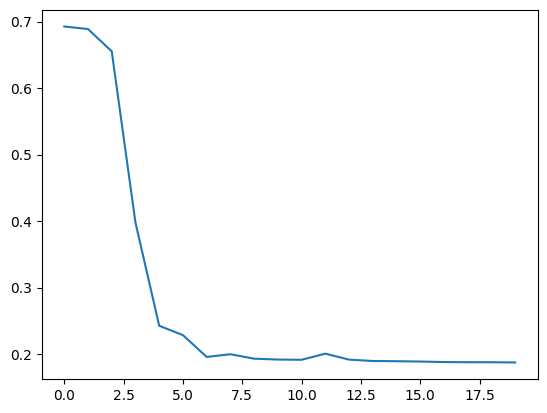

In [18]:
plt.plot([jnp.array(l).mean() for l in training_losses])

In [27]:
with open('param_file.pkl', 'wb') as params_file:
    pickle.dump(state.params, params_file)

In [28]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [29]:
fork_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/030_fork/nontextured.ply'
knife_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/032_knife/nontextured.ply'
box_mesh_path = b.utils.get_assets_dir() + '/bop/ycbv/models/obj_000002.ply'
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'
fork_scale = knife_scale = 1.0
box_scale = 1e-3
table_scale = 1e-6
mesh_paths = (fork_mesh_path, knife_mesh_path, box_mesh_path, table_mesh_path)
scales = (fork_scale, knife_scale, box_scale, table_scale)
for mesh_path, scale in zip(mesh_paths, scales):
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=scale)

Centering mesh with translation [-0.02541  -0.022295  0.007042]
Centering mesh with translation [-0.019428  -0.0274155  0.003918 ]


In [30]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3

SHIFT_MIN = -0.2
SHIFT_SCALE = 0.4
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.1, 0.0])

In [31]:
def fork_spoon_from_known_params(is_fork, shift):
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift*jnp.cos(jnp.pi/12), -0.05 + shift*jnp.sin(jnp.pi/12), 10*jnp.pi/12]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    return (is_fork, rendered)

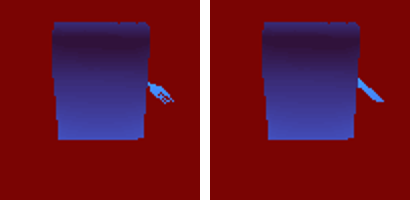

In [32]:
ss = -0.1
b.viz.hstack_images([b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(True, ss)[1][...,2]), 2),
                     b.viz.scale_image(b.get_depth_image(fork_spoon_from_known_params(False, ss)[1][...,2]), 2)])

In [39]:
make_onehot = lambda b: jax.lax.cond(b, lambda: jnp.array([0.0, 1.0]), lambda: jnp.array([1.0, 0.0]))

true: [1. 0.] predicted: [[0.4873311 0.5126689]]


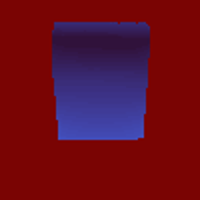

In [45]:
is_fork, __img, = fork_spoon_from_known_params(False, 0.0)
__img = __img[:, :, 2].reshape(1, 100, 100, 1)
logits = state.apply_fn({'params': state.params}, __img)

print(f'true: {make_onehot(is_fork)} predicted: {jax.nn.softmax(logits)}')

b.viz.scale_image(b.get_depth_image(__img.reshape(100, 100)), 2)

In [19]:
#img_batch, label_batch = make_batch(batch_keys)
#logits = state.apply_fn({'params': state.params}, img_batch)

In [20]:
#i = 33 #23 # 13

In [21]:
#b.viz.scale_image(b.get_depth_image(img_batch[i, :, :, 0]), 2)

In [22]:
#label_batch[i], jax.nn.softmax(logits[i])

## 